In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import scipy.stats
import numpy as np
from scipy.stats import truncnorm
from scipy.stats import multivariate_normal
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from scipy.stats import norm

In [3]:
# Hyper parameters for testing purposes

N = 10_000
s_1 = np.zeros(N)
s_2 = np.zeros(N)
sig_t = 5
A = np.array([[1, -1]])
t = np.zeros(N)
sigma_s = np.array([[100, 0], [0, 100]]) 
mu_matrix = np.array([100, 100]) 

s_1[0] = 100
s_2[0] = 100
t[0] = 20


# Q4

In [4]:
#Gibbs function
def gibbs_sample(N, burn, mu_s1, var_s1, mu_s2, var_s2, y):

    # N total iterations
    # [N - burn] values are returned

    s_1 = np.zeros(N)
    s_2 = np.zeros(N)
    t = np.zeros(N)

    sigma_s = np.array([[var_s1, 0], [0, var_s2]]) 

    # print(f"sigma_s: {sigma_s}\n")

    mu_matrix = np.array([[mu_s1], [mu_s2]]) 

    # print(f"mu matrix: {mu_matrix}\n")

    s_1[0] = np.random.normal(mu_s1, np.sqrt(var_s1))
    s_2[0] = np.random.normal(mu_s2, np.sqrt(var_s2))
    
    mu_t = mu_s1 - mu_s2 # to calc mu_t before game with anterior skills
    sig_t = var_s1 + var_s2

    y = y

    # do heavy calculations before loop
    A = np.array([[1, -1]])
    sigma_st = np.linalg.inv(np.linalg.inv(sigma_s) + A.transpose()*(sig_t**(-1))*A)
    sig_s__mu_mat = np.matmul(np.linalg.inv(sigma_s),mu_matrix)
    A_t__sig_t = A.transpose()*(sig_t**(-1))
  
    for n in range(N-1):
        
        mu_t = s_1[n] - s_2[n]                  # calc mu_t with prior skills
        a, b = (-mu_t)/np.sqrt(sig_t), np.inf   # truncated normal limits

        # Draw new t sample
        if(y == 1):
            t[n+1] = truncnorm.rvs(a, b, loc= mu_t, scale = np.sqrt(sig_t), size=1)
        else:
            t[n+1] = truncnorm.rvs(-b, a, loc= mu_t, scale = np.sqrt(sig_t), size=1)

        # Draw new s samples using new t sample
        mu_st = np.matmul(sigma_st,(sig_s__mu_mat + A_t__sig_t*t[n+1]))
        new_s = np.random.multivariate_normal([mu_st[0][0], mu_st[1][0]], sigma_st)

        s_1[n+1] = new_s[0]
        s_2[n+1] = new_s[1]

    return(s_1[burn:], s_2[burn:], t[burn:])

In [5]:
# Q4 running code

iter = 10000
burn = 2000
s1, s2, t = gibbs_sample(iter, 0, 25, 25/3, 25, 25/3, 1)

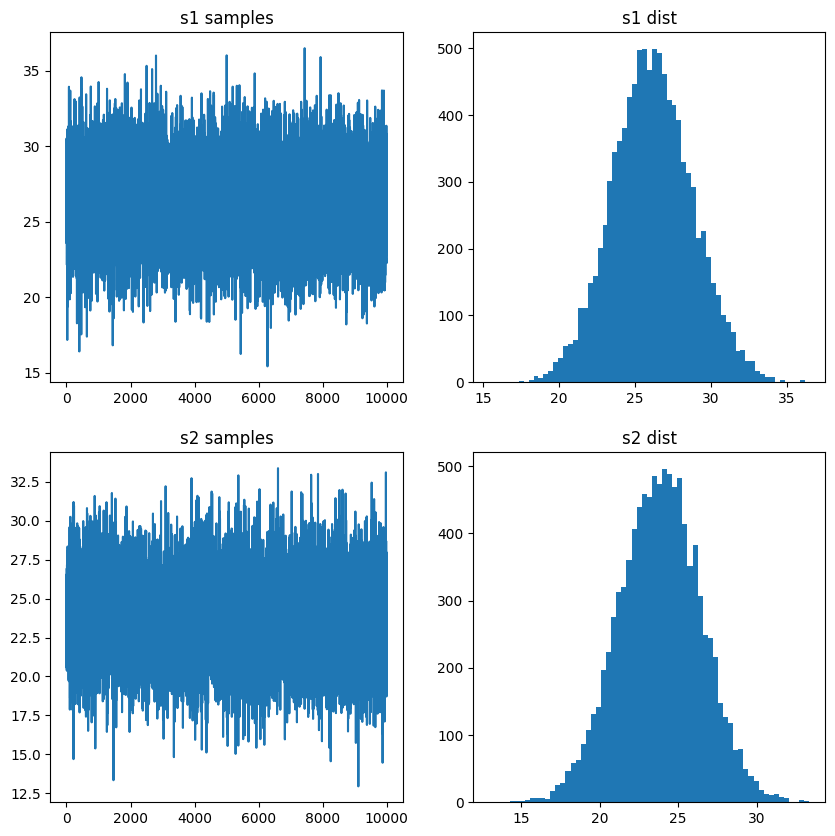

mean_s1 = 26.1601769993182, var_s1 = 7.047269867503837
mean_s2 = 23.83653785419254, var_s2 = 6.855033011983524


In [6]:
# Q4 plotting code

iterations_num = [i + 1 for i in range(iter-0)]

plt.rcParams['figure.figsize'] = [10, 10]

# 2x2 grid with plots
fig, axs = plt.subplots(2, 2)

#plot s1 samples and hist
axs[0, 0].plot(iterations_num,s1)
axs[0, 0].set_title("s1 samples")
axs[0, 1].hist(s1,bins = "auto")
axs[0, 1].set_title("s1 dist")

# plot s2 samples and hist
axs[1, 0].plot(iterations_num,s2)
axs[1, 0].set_title("s2 samples")
axs[1, 1].hist(s2,bins = "auto")
axs[1, 1].set_title("s2 dist")
plt.show()

#print posterior parameters mu and var
print(f"mean_s1 = {np.mean(s1)}, var_s1 = {np.var(s1)}")
print(f"mean_s2 = {np.mean(s2)}, var_s2 = {np.var(s2)}")

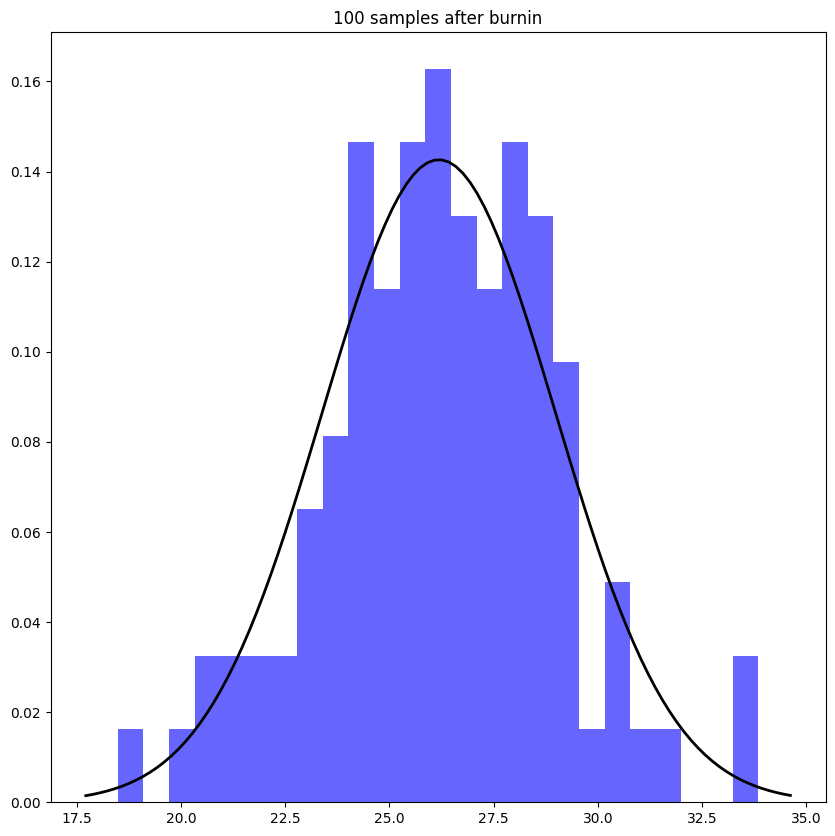

In [7]:
# Q4 code for testing different iterations

iter = 125 #125 1250 6250 10000
burn = 25  #25 250 1250 2000

s1, s2, t = gibbs_sample(iter, burn, 25, 25/3, 25, 25/3, 1)

# parameters for the gauss curve
mu, std = norm.fit(s1)

# histogram plot
plt.hist(s1, bins = 25, density=True, alpha = 0.6, color = "b")

# curve plot
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth= 2)

title = f"{iter-burn} samples after burnin"
plt.title(title)

plt.show()


# Q5

In [10]:
# READ DATA FILE
data = pd.read_csv("SerieA.csv", delimiter=",")
print(data)

     yyyy-mm-dd  HH:MM       team1     team2  score1  score2
0    2018-08-18  18:00      Chievo  Juventus       2       3
1    2018-08-18  20:30       Lazio    Napoli       1       2
2    2018-08-19  18:00      Torino      Roma       0       1
3    2018-08-19  20:30    Sassuolo     Inter       1       0
4    2018-08-19  20:30       Parma   Udinese       2       2
..          ...    ...         ...       ...     ...     ...
375  2019-05-26  20:30        Roma     Parma       2       1
376  2019-05-26  20:30       Inter    Empoli       2       1
377  2019-05-26  20:30  Fiorentina     Genoa       0       0
378  2019-05-26  20:30    Cagliari   Udinese       1       2
379  2019-05-26  20:30    Atalanta  Sassuolo       3       1

[380 rows x 6 columns]


In [11]:
# Extract relevant data

# names of teams in serie a
teams = data["team1"].unique()

# set initial skill, Microsoft sets new players as mu = 25 and sigma = 25/3
init_s = 25
init_var = 25/3

#assign skill and var
team_skills = {}
for team in teams:
    team_skills[team] = [init_s, init_var] #team_skills = {teamname : [mean, var]}

In [12]:
# GIBBS SAMPLE EVERY MATCH

# iterate over matches
for index, match in data.iterrows():
    # identify teams
    team1 = match['team1']
    team2 = match['team2']

    print(f"{round(100*(index+1)/380,2)}%---------------------------------------------") #qol prints

    #ignore draws
    if(match["score1"] == match["score2"]):
        print("Draw")
        continue

    # find current team values
    mu_s1, mu_s2 = team_skills[team1][0], team_skills[team2][0]
    var_s1, var_s2 = team_skills[team1][1], team_skills[team2][1]

    # number of iterations in gibbs sampling
    iter = 2500
    burn = 500

    # check what team won
    if(match["score1"] > match["score2"]):
        y = 1
        print(f"{team1} vs {team2} -> {team1} won")
    else:
        y = -1
        print(f"{team1} vs {team2} -> {team2} won")

    # call sample func
    s1, s2, t = gibbs_sample(iter, burn, mu_s1, var_s1, mu_s2, var_s2, y)

    #calc new mean and var
    new_mu_s1 = np.mean(s1)
    new_mu_s2 = np.mean(s2)
    
    new_var_s1 = np.var(s1)
    new_var_s2 = np.var(s2)

    # print parameter changes
    print(f"{team1}: [{round(mu_s1,2)} -> {round(new_mu_s1,2)}] & [{round(var_s1,2)} -> {round(new_var_s1,2)}]") 
    print(f"{team2}: [{round(mu_s2,2)} -> {round(new_mu_s2,2)}] & [{round(var_s2,2)} -> {round(new_var_s2,2)}]")

    # update team parameters
    team_skills[team1] = [new_mu_s1, new_var_s1]
    team_skills[team2] = [new_mu_s2, new_var_s2]

0.26%---------------------------------------------
Chievo vs Juventus -> Juventus won
Chievo: [25 -> 23.82] & [8.33 -> 6.76]
Juventus: [25 -> 26.15] & [8.33 -> 6.75]
0.53%---------------------------------------------
Lazio vs Napoli -> Napoli won
Lazio: [25 -> 23.89] & [8.33 -> 7.5]
Napoli: [25 -> 26.16] & [8.33 -> 6.84]
0.79%---------------------------------------------
Torino vs Roma -> Roma won
Torino: [25 -> 23.81] & [8.33 -> 6.84]
Roma: [25 -> 26.05] & [8.33 -> 7.25]
1.05%---------------------------------------------
Sassuolo vs Inter -> Sassuolo won
Sassuolo: [25 -> 26.14] & [8.33 -> 6.72]
Inter: [25 -> 23.97] & [8.33 -> 6.93]
1.32%---------------------------------------------
Draw
1.58%---------------------------------------------
Empoli vs Cagliari -> Empoli won
Empoli: [25 -> 26.18] & [8.33 -> 6.96]
Cagliari: [25 -> 23.83] & [8.33 -> 7.12]
1.84%---------------------------------------------
Bologna vs Spal -> Spal won
Bologna: [25 -> 23.78] & [8.33 -> 7.3]
Spal: [25 -> 26.18] &

In [13]:
# sort after mu and print

sorted_teams = sorted(team_skills.keys(), key = lambda k: team_skills[k][0], reverse=True)

for i in range(len(sorted_teams)):
    print(f"{sorted_teams[i]}: {round(team_skills[sorted_teams[i]][0],2)}, {round(team_skills[sorted_teams[i]][1],2)}")

Atalanta: 26.46, 0.24
Napoli: 26.02, 0.21
Milan: 25.96, 0.24
Roma: 25.95, 0.22
Inter: 25.77, 0.2
Torino: 25.77, 0.2
Juventus: 25.47, 0.23
Bologna: 25.38, 0.15
Lazio: 25.25, 0.14
Udinese: 25.04, 0.17
Empoli: 25.0, 0.15
Spal: 24.96, 0.15
Sampdoria: 24.84, 0.12
Cagliari: 24.51, 0.13
Genoa: 24.42, 0.24
Parma: 24.02, 0.22
Sassuolo: 23.95, 0.37
Frosinone: 23.56, 0.24
Fiorentina: 23.49, 0.22
Chievo: 22.87, 0.75


In [14]:
# calculate a skill measure / rank 
def getrank(mu, var):
    return mu-3*var

# put skill measure next to data
for team in team_skills.keys():
    [mu, var] = team_skills[team]
    team_skills[team] = [mu, var, getrank(mu, var)]

# sort after skill measure
sorted_teams = sorted(team_skills.keys(), key = lambda k: team_skills[k][2], reverse=True) 

# print standings
for i in range(len(sorted_teams)):
    print(f"{sorted_teams[i]}: {round(team_skills[sorted_teams[i]][0],2)}, {round(team_skills[sorted_teams[i]][1],2)}, {round(team_skills[sorted_teams[i]][2], 2)}")

Atalanta: 26.46, 0.24, 25.73
Napoli: 26.02, 0.21, 25.38
Roma: 25.95, 0.22, 25.28
Milan: 25.96, 0.24, 25.24
Inter: 25.77, 0.2, 25.18
Torino: 25.77, 0.2, 25.16
Bologna: 25.38, 0.15, 24.92
Lazio: 25.25, 0.14, 24.82
Juventus: 25.47, 0.23, 24.79
Empoli: 25.0, 0.15, 24.55
Udinese: 25.04, 0.17, 24.54
Spal: 24.96, 0.15, 24.51
Sampdoria: 24.84, 0.12, 24.49
Cagliari: 24.51, 0.13, 24.12
Genoa: 24.42, 0.24, 23.71
Parma: 24.02, 0.22, 23.36
Frosinone: 23.56, 0.24, 22.83
Sassuolo: 23.95, 0.37, 22.83
Fiorentina: 23.49, 0.22, 22.83
Chievo: 22.87, 0.75, 20.62


# Q6

In [15]:
# make prediction using cumulative distribution function of t
def prediction(mu_s1, sig_s1, mu_s2, sig_s2):

    #parameters for t
    mu_t = mu_s1 - mu_s2
    sig_t = sig_s1 + sig_s2

    # z-score for 0
    zscore = (0 - mu_t) / np.sqrt(sig_t)

    #cdf to find prob
    prob = 1 - scipy.stats.norm.cdf(zscore)

    # make guess accordingly
    if prob > 0.5:
        return 1
    else: return -1

In [17]:
# test prediction function

# teams with equal parameters -> always predicts team 2
# makes first round of matches random guesses entirely

prediction(25, 8, 25 ,8) 

-1

In [18]:
# Run Gibbs sampling for serie a 2018 with integrated predictions

n_tot = 0 # total number of guesses
n_cor = 0 # number of correct guesses

for index, match in data.iterrows():
    # identify teams
    team1 = match['team1']
    team2 = match['team2']
    print(f"{round(100*(index+1)/380,2)}%---------------------------------------------")

    #ignore draws
    if(match["score1"] == match["score2"]):
        print("Draw")
        continue

    # find current team values
    mu_s1, mu_s2 = team_skills[team1][0], team_skills[team2][0]
    var_s1, var_s2 = team_skills[team1][1], team_skills[team2][1]

    #number of iterations in gibbs sampling
    iter = 1000

    #check what team won
    if(match["score1"] > match["score2"]):
        y = 1
        print(f"{team1} vs {team2} -> {team1} won")
    else:
        y = -1
        print(f"{team1} vs {team2} -> {team2} won")

    # make prediction on prior knowledge
    pred = prediction(mu_s1, var_s1, mu_s2, var_s2)
    n_tot += 1 # another guess made

    # check if prediction was correct
    if pred == y:
        n_cor += 1 # another correct guess made
        print("prediction was correct")
    else:
        print("prediciton was wrong")


    # call sample func
    s1, s2, t = gibbs_sample(2500, 500, mu_s1, var_s1, mu_s2, var_s2, y)

    #calc new mean and var
    new_mu_s1 = np.mean(s1)
    new_mu_s2 = np.mean(s2)
    
    new_var_s1 = np.var(s1)
    new_var_s2 = np.var(s2)

    # print parameter changes
    print(f"{team1}: [{round(mu_s1,2)} -> {round(new_mu_s1,2)}] & [{round(var_s1,2)} -> {round(new_var_s1,2)}]") 
    print(f"{team2}: [{round(mu_s2,2)} -> {round(new_mu_s2,2)}] & [{round(var_s2,2)} -> {round(new_var_s2,2)}]")

    # update team parameters
    team_skills[team1] = [new_mu_s1, new_var_s1]
    team_skills[team2] = [new_mu_s2, new_var_s2]

0.26%---------------------------------------------
Chievo vs Juventus -> Juventus won
prediction was correct
Chievo: [22.87 -> 22.82] & [0.75 -> 0.73]
Juventus: [25.47 -> 25.49] & [0.23 -> 0.22]
0.53%---------------------------------------------
Lazio vs Napoli -> Napoli won
prediction was correct
Lazio: [25.25 -> 25.2] & [0.14 -> 0.13]
Napoli: [26.02 -> 26.09] & [0.21 -> 0.19]
0.79%---------------------------------------------
Torino vs Roma -> Roma won
prediction was correct
Torino: [25.77 -> 25.61] & [0.2 -> 0.17]
Roma: [25.95 -> 26.11] & [0.22 -> 0.19]
1.05%---------------------------------------------
Sassuolo vs Inter -> Sassuolo won
prediciton was wrong
Sassuolo: [23.95 -> 24.68] & [0.37 -> 0.27]
Inter: [25.77 -> 25.36] & [0.2 -> 0.17]
1.32%---------------------------------------------
Draw
1.58%---------------------------------------------
Empoli vs Cagliari -> Empoli won
prediction was correct
Empoli: [25.0 -> 25.07] & [0.15 -> 0.13]
Cagliari: [24.51 -> 24.44] & [0.13 -> 0.12]

In [19]:
# calculate and print prediction accuracy
r = n_cor / n_tot
print(f"Correct predictions: {100 * r}%")

Correct predictions: 70.95588235294117%
